# **Packages and Libraries Import**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from IPython.display import display
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.layers import BatchNormalization, Activation
import os
import json
import glob
import random
from PIL import Image
import pathlib
from google.colab import files
%matplotlib inline

In [2]:
# global seeds
import random, numpy as np, tensorflow as tf
SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

**Connect to drive and load the data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/data_final/brainmri.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data_final")

In [5]:
# Create a Path object representing the desired directory
data_dir = pathlib.Path('/content/data_final/kaggle_3m')

# Change the current working directory
import os
os.chdir(data_dir)

# Verify the current working directory
print(os.getcwd())  # Output: /content/data_final/kaggle_3m

/content/data_final/kaggle_3m


# **EDA**

In [7]:
brain_df=pd.read_csv('data_mask.csv')

In [8]:
# optimize GPU work
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [9]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [10]:
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [11]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [12]:
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [13]:
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

In [14]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

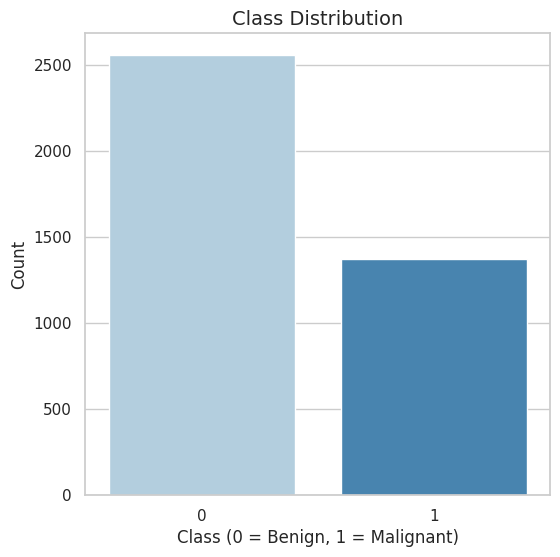

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Count plot for class distribution
plt.figure(figsize=(6, 6))
ax = sns.countplot(x=brain_df['mask'], palette="Blues")

ax.set_title("Class Distribution", fontsize=14)
ax.set_xlabel("Class (0 = Benign, 1 = Malignant)")
ax.set_ylabel("Count")

# Save the plot with transparent background
plt.savefig("class_distribution.png", transparent=True, dpi=300)
plt.show()

In [16]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

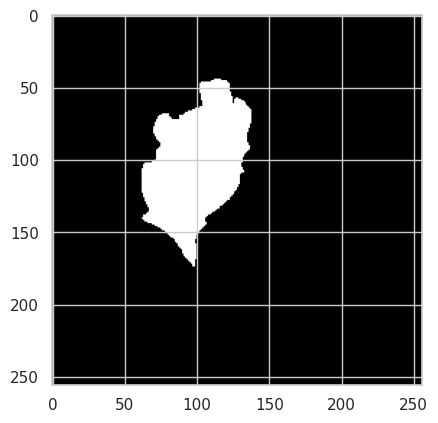

In [17]:
plt.imshow(cv2.imread(brain_df.mask_path[1789]))

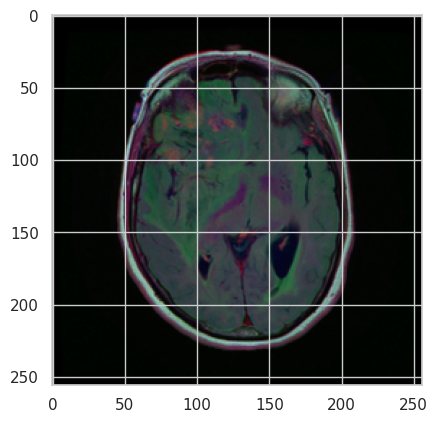

In [18]:
plt.imshow(cv2.imread(brain_df.image_path[1789]))

In [19]:
cv2.imread(brain_df.mask_path[1789]).max()

np.uint8(255)

In [20]:
cv2.imread(brain_df.mask_path[1789]).min()

np.uint8(0)

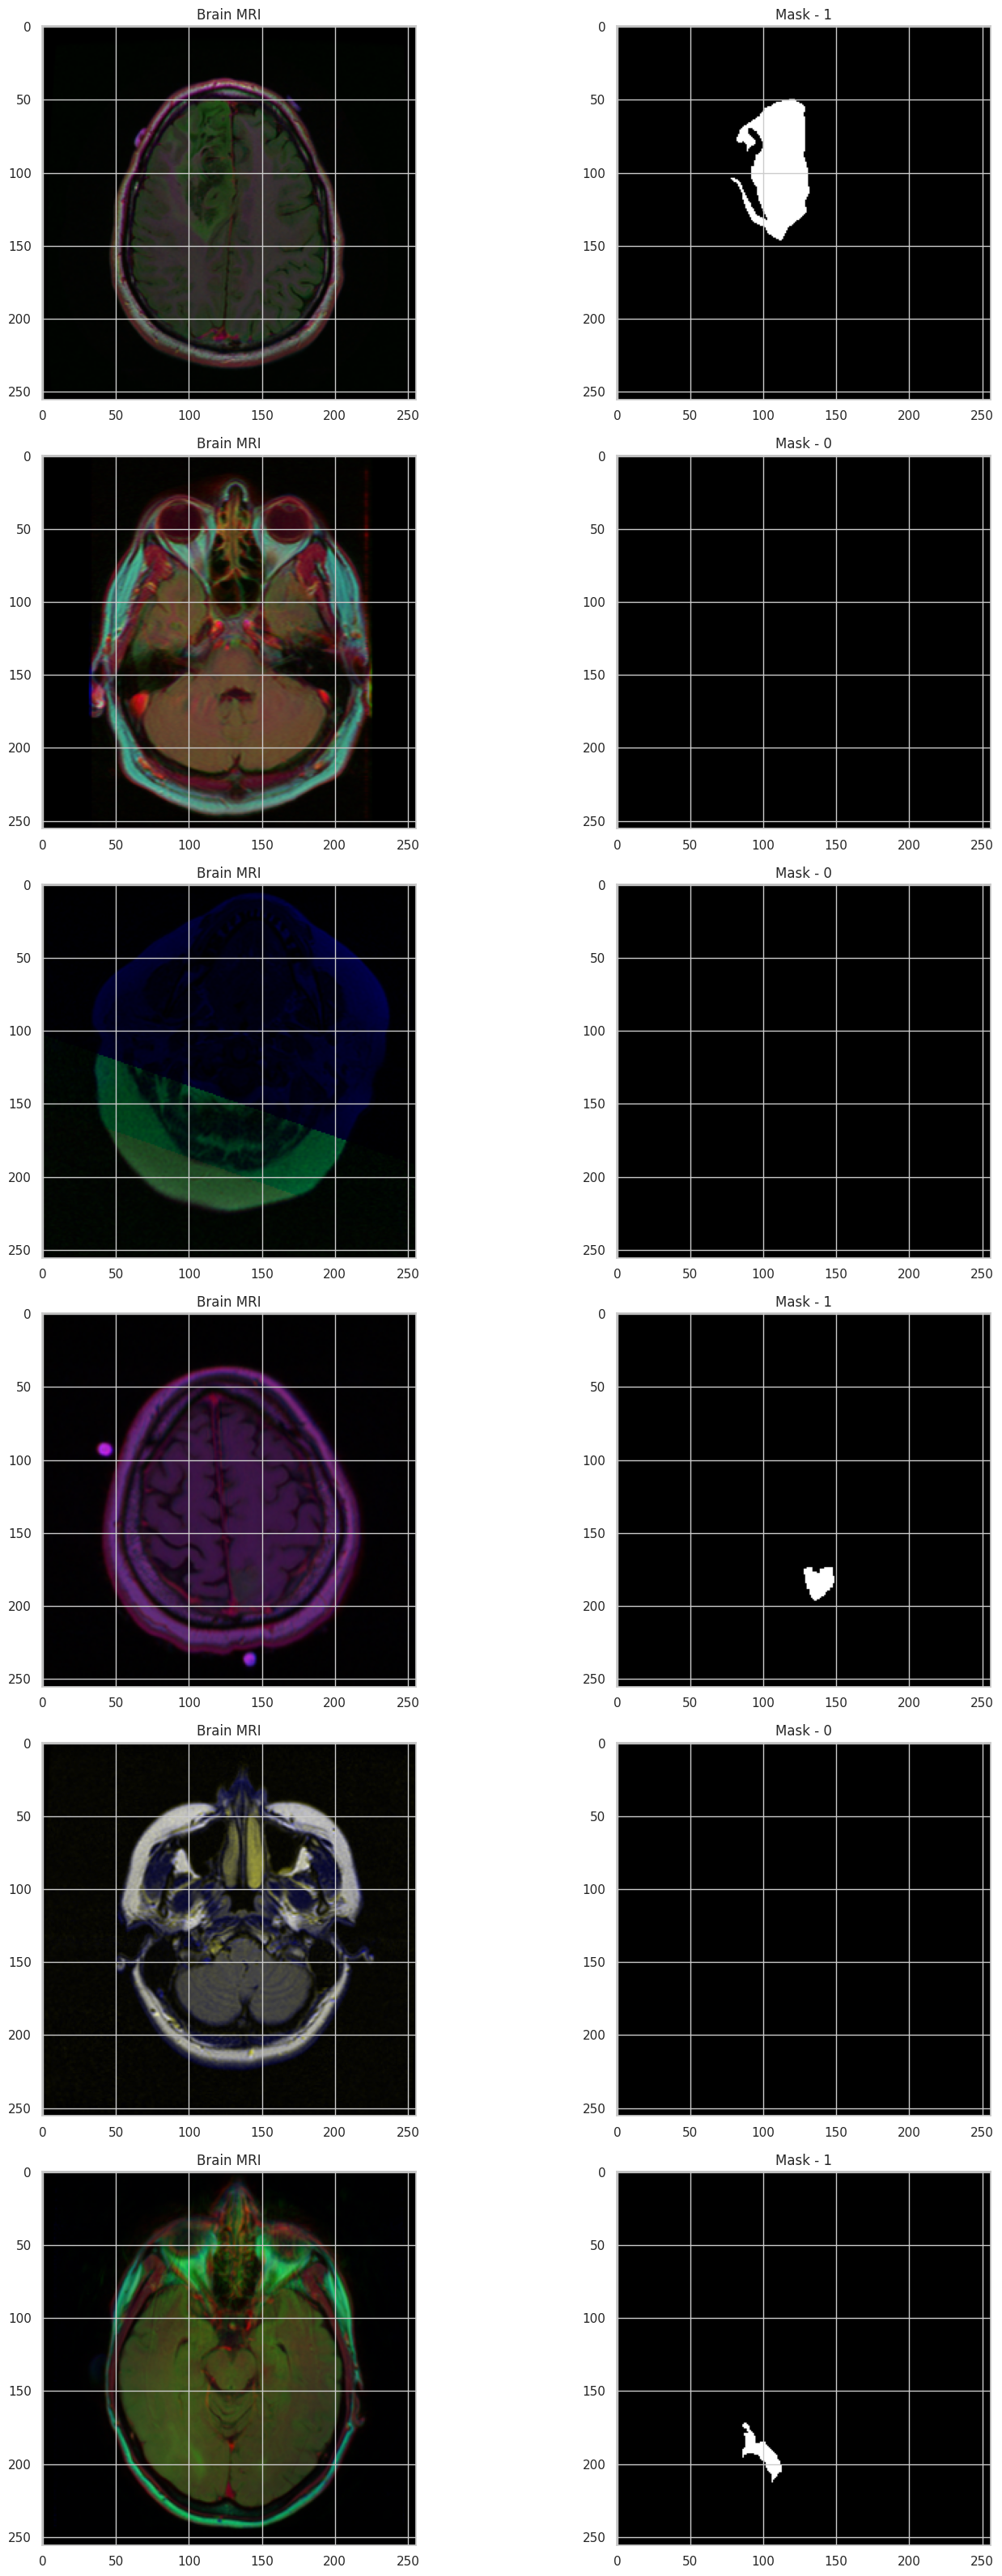

In [21]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

# Save the plot with transparent background
plt.savefig("img+mask.png", transparent=True, dpi=300)
fig.tight_layout()

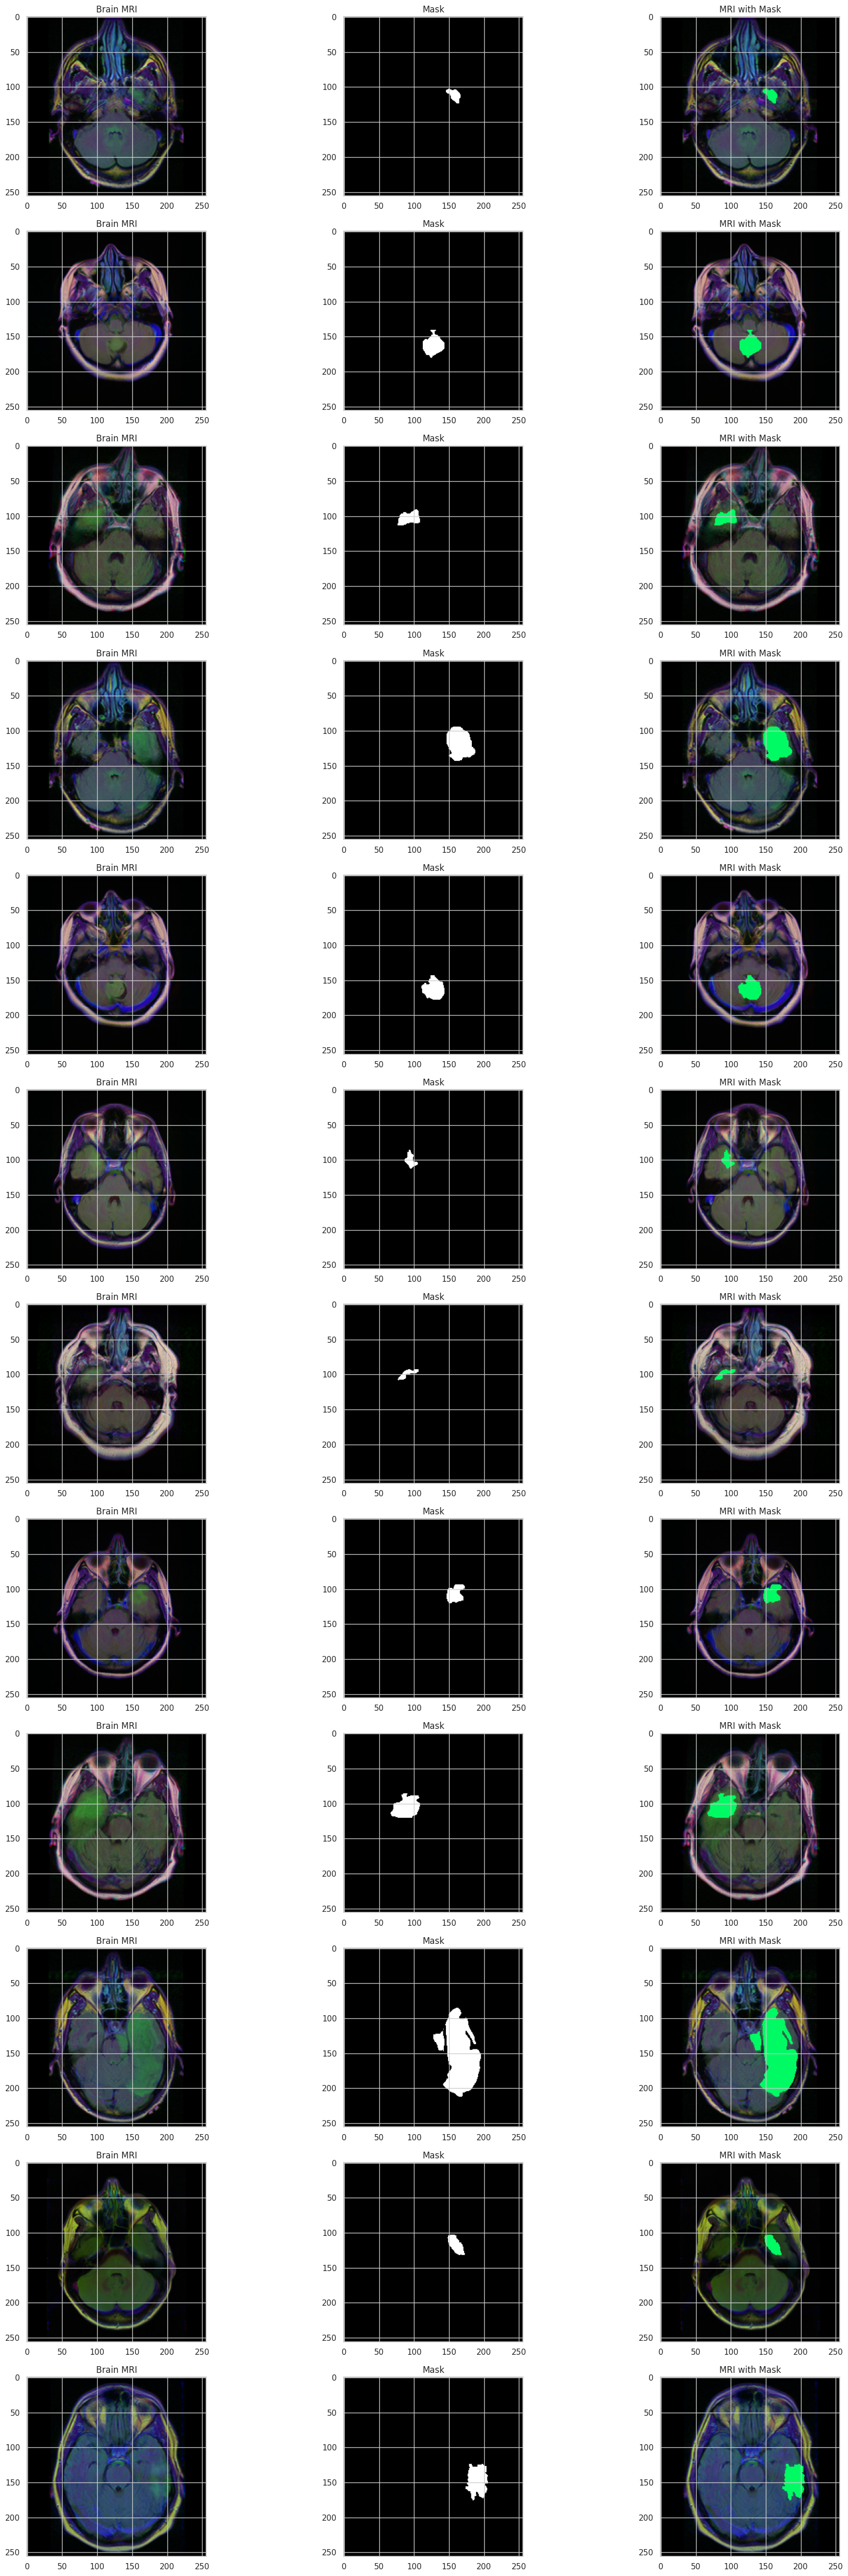

In [22]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')


    img[mask == 255] = (0,250,100)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

# Save the plot with transparent background
plt.savefig("img+mask_combo.png", transparent=True, dpi=300)
fig.tight_layout()

# **Classifier training:Transfer learning using ResNet50**

In [23]:
brain_df_train = brain_df.drop(columns=['patient_id', 'mask_path'])
brain_df_train.shape

(3929, 2)

In [24]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x)) # later for class_type=binary must be string, tuple or list

In [25]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask        3929 non-null   object
dtypes: object(2)
memory usage: 61.5+ KB


In [26]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15, random_state=42)

In [27]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [28]:
# image size
img_size = (256,256)

# batch size
batch_size = 128

In [29]:
# create image generator
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
   rescale=1/255., rotation_range=20,
   horizontal_flip=True, zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=batch_size,
shuffle=True,
seed=SEED,
class_mode="binary",
target_size=img_size
)


valid_generator=val_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=batch_size,
shuffle=False,
seed=SEED,
class_mode="binary",
target_size=img_size
)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=batch_size,
shuffle=False,
seed=SEED,
class_mode='binary',
target_size=img_size,
)


Found 3339 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [82]:
img_size
IMG_SIZE=img_size
BATCH_SIZE=batch_size

img_shape = img_size + (3,) # amount of rgb channels
img_shape

(256, 256, 3)

In [33]:
# restnet base model without top classification layers
basemodel = ResNet50(
    input_tensor=Input(shape=img_shape),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [35]:
basemodel.trainable = False # freezing the restnet base to train

In [36]:
len(basemodel.layers) # amount of layers

176

In [38]:
# resnet_output

In [39]:
resnet_model = tf.keras.Sequential([
    basemodel, # adding pre-trained ResNet50 model

    layers.Dense(256, use_bias=False),
    # layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')  # for the binary classification output
])

In [40]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.95, # rate of decrease
    staircase=True
)

In [41]:
# Compile the model structure for training
base_learning_rate = 0.1

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

resnet_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

In [42]:
# Define callbacks
drive_model_path = '/content/data_final/classifier_model_resnet_weightsnorm.keras'

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath=drive_model_path, verbose=1, monitor='val_accuracy', save_best_only=True)
]


In [43]:
epochs_init = 100

In [44]:
train_generator

In [45]:
# to calculate weights instead of doing it intuitively
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get labels as a NumPy array
y = brain_df['mask'].values  # This will be an array of 0s (benign) and 1s (malignant)

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# Map to class index
class_weight_dict = {i: weight for i, weight in zip(np.unique(y), class_weights)}

print("Class weights:", class_weight_dict)

Class weights: {np.int64(0): np.float64(0.7685837245696401), np.int64(1): np.float64(1.4308084486525856)}


In [46]:
weights = {0: 0.75, 1: 1.5}

## **Training and saving the best model**

In [47]:
import json

# Train the model with callbacks
history_head = resnet_model.fit(
    train_generator,
    epochs=epochs_init,
    validation_data=valid_generator,
    callbacks=callbacks, # to customize the training process
    class_weight=weights,
    verbose=1,  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4717 - loss: 0.9100
Epoch 1: val_accuracy improved from -inf to 0.34000, saving model to /content/data_final/classifier_model_resnet_weightsnorm.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4724 - loss: 0.9070 - val_accuracy: 0.3400 - val_loss: 0.7763
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5377 - loss: 0.7169
Epoch 2: val_accuracy improved from 0.34000 to 0.39200, saving model to /content/data_final/classifier_model_resnet_weightsnorm.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5382 - loss: 0.7163 - val_accuracy: 0.3920 - val_loss: 0.7392
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5413 - loss: 0.6857
Epoch 3: val_accuracy improved from 0.39200 to 0.69000, saving model to /content/data_final/classifier_model_resnet_weightsnorm.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5430 - loss: 0.6852 - val_accuracy: 0.6900 - val_loss: 0.6111
Epoc

In [49]:
# Define the path to save the file in Google Drive
drive_path = '/content/data_final/training_history_resnet_weightsnorm.json'

# Save the training history to Google Drive
with open(drive_path, 'w') as file:
    json.dump(history_head.history, file)

In [50]:
# save the model architecture to h5
resnet_model.save('classifier_resnet_model_weightsnorm.keras')

# model_json = model.to_json()
# with open("classifier-resnet-model.json","w") as json_file:
#   json_file.write(model_json)

## **Trained model's performance assessment**

In [51]:
# load training history
with open(drive_path, 'r') as file:
  training_history = json.load(file)

In [52]:
# training and fine tuning metrics
acc = training_history['accuracy']
val_acc = training_history['val_accuracy']
loss = training_history['loss']
val_loss = training_history['val_loss']

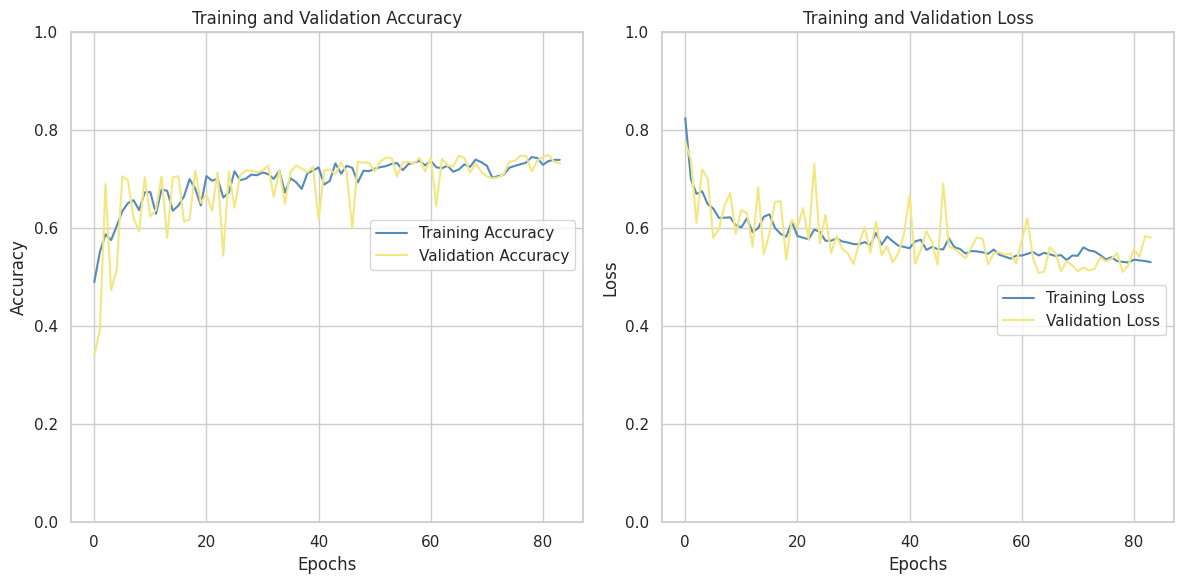

In [53]:
# Plot accuracy and loss on the same grid
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', color='#568ab9')
plt.plot(val_acc, label='Validation Accuracy', color='#f3e780')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.ylim(0, 1)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='#568ab9')
plt.plot(val_loss, label='Validation Loss', color='#f3e780')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## **Fine tuning**

In [54]:
# resnet_model.trainable = True  # unfreezing for fine-tuning

In [55]:
# # getting layers from the model
# resnet_core = resnet_model.layers[0]

In [56]:
# len(resnet_core.layers)

In [57]:
# # freeze layers
# for layer in resnet_core.layers[:120]:
#   layer.trainable = False

In [58]:
# tune_lr = base_learning_rate / 1000

In [59]:
# # Same
# resnet_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=tune_lr),     # Adam deals with gradient descent
#     loss='binary_crossentropy',   # measures the difference between two probability distributions
#     metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]    # calculates how often predictions match binary labels
# )

In [60]:
# # Define callbacks
# drive_model_path_ft = '/content/data_final/classifier_model_resnet_ft_weights1704.keras'

# # to dicrease overall model calculation time if there is no improvement
# early_stopping_ft = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)

# # save the best model with min validation loss
# checkpointer_ft = ModelCheckpoint(filepath=drive_model_path_ft, verbose=1, save_best_only=True)

In [61]:
# epochs_ft = 100
# epochs_ft = epochs_init + epochs_ft

In [62]:
# # Fine-tune the model
# history_ft = resnet_model.fit(
#     train_generator,
#     epochs=epochs_ft,
#     initial_epoch=history.epoch[-1],  # Continue from where the initial training ended
#     validation_data=valid_generator,
#     callbacks=[early_stopping_ft, checkpointer_ft],  # Add callbacks
#     verbose=1
# )

# # Define the path to save the file in Google Drive
# drive_path_ft = '/content/data_final/history_ft_weights1704.json'

# # Save the training history to Google Drive
# with open(drive_path_ft, 'w') as file:
    # json.dump(history_ft.history, file)

## Checkpoint to close the previous chapter

In [63]:
resnet_model.save_weights('classifier_resnet_model_weightsnorm.weights.h5')

In [64]:
resnet_model.load_weights('classifier_resnet_model_weightsnorm.weights.h5')

In [65]:
# getting layers from the model
resnet_core = resnet_model.layers[0]

In [66]:
# unfreeze last 10 layers
for layer in resnet_core.layers[-10:]:
  layer.trainable = True

In [67]:
for layer in resnet_core.layers:
  if layer.trainable == True:
    print(layer, layer.trainable)

<BatchNormalization name=conv5_block3_1_bn, built=True> True
<Activation name=conv5_block3_1_relu, built=True> True
<Conv2D name=conv5_block3_2_conv, built=True> True
<BatchNormalization name=conv5_block3_2_bn, built=True> True
<Activation name=conv5_block3_2_relu, built=True> True
<Conv2D name=conv5_block3_3_conv, built=True> True
<BatchNormalization name=conv5_block3_3_bn, built=True> True
<Add name=conv5_block3_add, built=True> True
<Activation name=conv5_block3_out, built=True> True
<GlobalAveragePooling2D name=avg_pool, built=True> True


In [68]:
tune_lr = base_learning_rate / 1000

In [69]:
# Same
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=tune_lr),     # Adam deals with gradient descent
    loss='binary_crossentropy',   # measures the difference between two probability distributions
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]    # calculates how often predictions match binary labels
)

In [70]:
# Define callbacks
drive_model_path_ft = '/content/data_final/classifier_resnet_model_ft_weightsnorm_10layers.keras'

# to dicrease overall model calculation time if there is no improvement
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)

# save the best model with min validation loss
checkpointer_ft = ModelCheckpoint(filepath=drive_model_path_ft, verbose=1, save_best_only=True)

In [71]:
epochs_ft = 100
epochs_ft = epochs_init + epochs_ft

In [73]:
# Fine-tune the model
history_ft = resnet_model.fit(
    train_generator,
    epochs=epochs_ft,
    initial_epoch=history_head.epoch[-1],  # Continue from where the initial training ended
    validation_data=valid_generator,
    callbacks=[early_stopping_ft, checkpointer_ft],
    verbose=1
)

Epoch 84/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6607 - loss: 2.4031
Epoch 84: val_loss improved from inf to 0.74525, saving model to /content/data_final/classifier_resnet_model_ft_weightsnorm_10layers.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6600 - loss: 2.3719 - val_accuracy: 0.4780 - val_loss: 0.7452
Epoch 85/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6819 - loss: 0.5388
Epoch 85: val_loss improved from 0.74525 to 0.65629, saving model to /content/data_final/classifier_resnet_model_ft_weightsnorm_10layers.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6826 - loss: 0.5381 - val_accuracy: 0.7140 - val_loss: 0.6563
Epoch 86/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7480 - loss: 0.4631
Epoch 86: val_loss improved from 0.65629 to 0.58858, saving model to /content/data_final/classifier_resnet_model_ft_weightsnorm_10layers.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7478 - loss: 0.4632 - val_accuracy: 0

In [74]:
# Define the path to save the file in Google Drive
drive_path_ft = '/content/data_final/history_ft_weightsnorm_10layers.json'

# Save the training history to Google Drive
with open(drive_path_ft, 'w') as file:
    json.dump(history_ft.history, file)

In [75]:
resnet_model.save_weights('classifier_resnet_model_ft_weightsnorm_10layers.weights.h5')

In [76]:
# fine-tuning history
with open('/content/data_final/history_ft_weightsnorm_10layers.json', 'r') as file:
    history_ft = json.load(file)

In [77]:
# Combine training and fine-tuning metrics
acc_ft = training_history['accuracy'] + history_ft['accuracy']
val_acc_ft = training_history['val_accuracy'] + history_ft['val_accuracy']

loss_ft = training_history['loss'] + history_ft['loss']
val_loss_ft = training_history['val_loss'] + history_ft['val_loss']

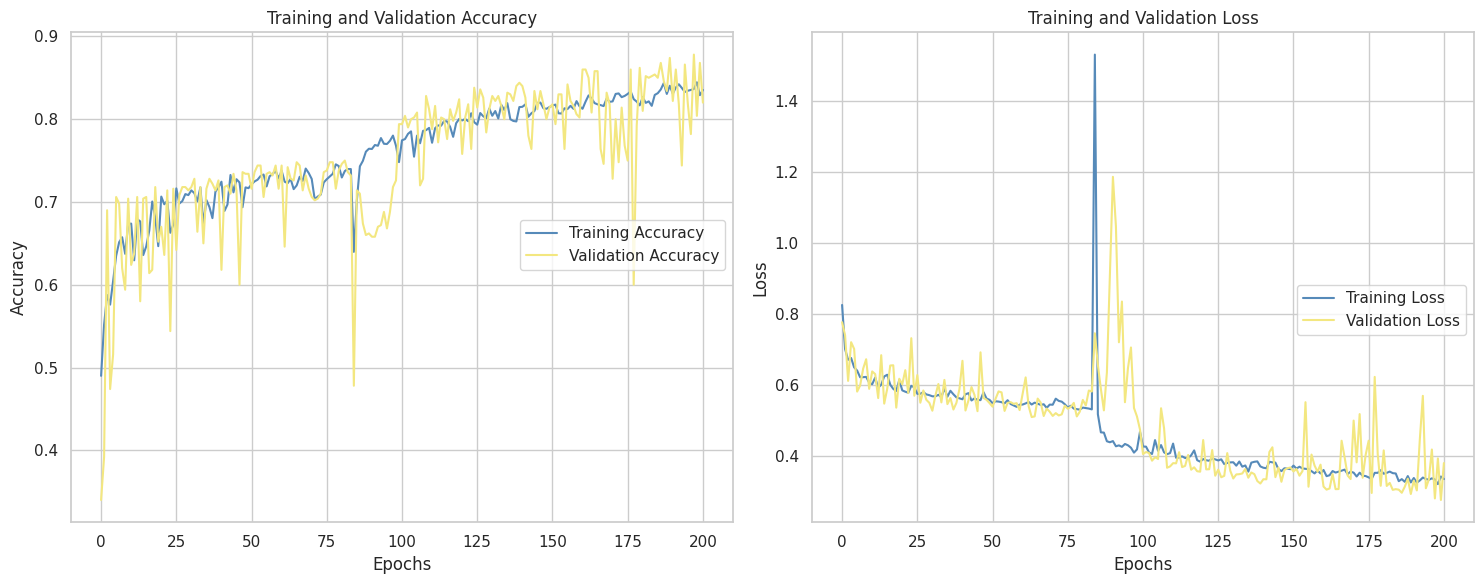

In [78]:
# Plot accuracy and loss on the same grid
plt.figure(figsize=(15, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc_ft, label='Training Accuracy', color='#568ab9')
plt.plot(val_acc_ft, label='Validation Accuracy', color='#f3e780')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss_ft, label='Training Loss', color='#568ab9')
plt.plot(val_loss_ft, label='Validation Loss', color='#f3e780')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [83]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pull X and y from DataFrame
X = brain_df_train[['image_path']]
y = brain_df_train['mask']

# Split into train & test
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42
)

# Build test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({
        'image_path': X_test_paths['image_path'],
        'mask'      : y_test
    }),
    directory='.',
    x_col='image_path',
    y_col='mask',
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary',
    target_size=IMG_SIZE
)

Found 590 validated image filenames belonging to 2 classes.


In [84]:
import os
print(os.listdir('/content'))


['.config', 'data_final', 'drive', '.ipynb_checkpoints', 'sample_data']


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


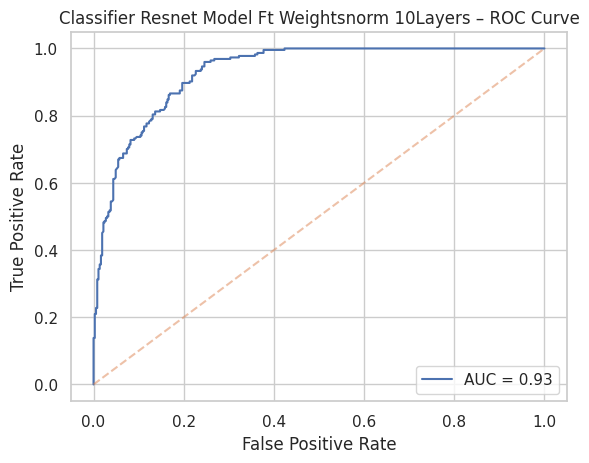

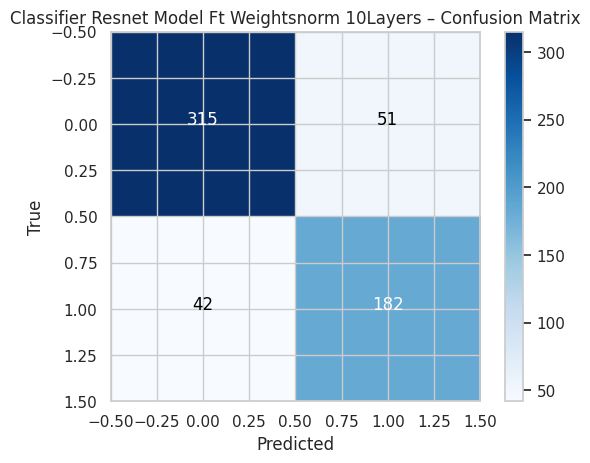


Classifier Resnet Model Ft Weightsnorm 10Layers Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       366
           1       0.78      0.81      0.80       224

    accuracy                           0.84       590
   macro avg       0.83      0.84      0.83       590
weighted avg       0.84      0.84      0.84       590



In [116]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

model_paths = [
    '/content/data_final/classifier_resnet_model_ft_weightsnorm_10layers.keras'
]

# compute steps & true labels:
n_samples = test_generator.n
batch_size = test_generator.batch_size
steps = math.ceil(n_samples / batch_size)
y_true = test_generator.classes


model = tf.keras.models.load_model(model_path)

# derive a clean name and base filename
base = model_path.split("/")[-1].replace(".keras", "")
name = base.replace("_", " ").title()

# Predict probabilities & binary labels
y_proba = model.predict(test_generator, steps=steps)
y_proba = y_proba[:, 0]
y_pred  = (y_proba > 0.5).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], "--", alpha=0.5)
plt.title(f"{name} – ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
roc_filename = f"{base}_roc_curve.png"
plt.savefig(roc_filename, transparent=True, bbox_inches="tight")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title(f"{name} – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center",
                  color="white" if cm[i,j] > cm.max()/2 else "black")
plt.colorbar()
cm_filename = f"{base}_confusion_matrix.png"
plt.savefig(cm_filename, transparent=True, bbox_inches="tight")
plt.show()

# Classification Report
print(f"\n{name} Classification Report:")
print(classification_report(y_true, y_pred))


# **Segmentation**

In [90]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# PARAMETERS
IMG_SIZE   = (256, 256)
BATCH_SIZE = 16
EPOCHS     = 20
AUTOTUNE   = tf.data.AUTOTUNE

In [91]:
import tensorflow as tf

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # input_shape = (batch, H, W, C)
        channels = input_shape[-1]
        # one γ and β per channel
        self.gamma = self.add_weight(
            name="gamma",
            shape=(channels,),
            initializer="ones",
            trainable=True,
        )
        self.beta = self.add_weight(
            name="beta",
            shape=(channels,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        # compute mean & var over spatial dims H,W for each sample & channel
        mean, var = tf.nn.moments(inputs, axes=[1,2], keepdims=True)
        x = (inputs - mean) / tf.sqrt(var + self.epsilon)
        # apply per‑channel scale & shift
        return x * self.gamma + self.beta

In [92]:
# TIFF LOADER
def _load_tiff(path):
    path = path.numpy().decode()
    arr = np.array(Image.open(path))
    # ensure channel dim for masks
    if arr.ndim == 2:
        arr = arr[..., None]
    return arr

def load_tif(path, channels):
    img = tf.py_function(func=_load_tiff, inp=[path], Tout=tf.uint8)
    img.set_shape([None, None, channels])
    return img

In [93]:
# PARSE FUNCTION
def parse_seg(img_path, mask_path):
    # image
    img = load_tif(img_path, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # mask
    mask = load_tif(mask_path, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.math.round(mask)   # force 0 or 1

    return img, mask

In [94]:
# FILTER TUMOR CASES
seg_df = brain_df[brain_df['mask'] == 1]
img_paths  = seg_df['image_path'].values
mask_paths = seg_df['mask_path'].values

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    img_paths, mask_paths,
    test_size=0.2,
    random_state=42
)

In [95]:
# BUILD TF.DATASETS
ds_train = (
    tf.data.Dataset
      .from_tensor_slices((train_imgs, train_masks))
      .shuffle(len(train_imgs))
      .map(parse_seg,    num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)
ds_val = (
    tf.data.Dataset
      .from_tensor_slices((val_imgs, val_masks))
      .map(parse_seg,    num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)

In [96]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Activation, Dropout

# BUILD A ResUNet
def build_resunet_instancenorm(input_shape=(256,256,3), dropout_rate=0.3):
    base = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    # gather skips
    skip_names = ["conv1_relu","conv2_block3_out","conv3_block4_out","conv4_block6_out"]
    skips = [base.get_layer(name).output for name in skip_names]
    x = base.output   # 8×8

    # existing decoder loop (8→16→32→64→128→256)
    for filters, skip in zip([512,256,128,64], reversed(skips)):
        x = tf.keras.layers.UpSampling2D((2,2))(x)
        x = tf.keras.layers.Concatenate()([x, skip])

        # first conv + InstanceNorm
        x = Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = InstanceNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)

        # second conv + InstanceNorm
        x = Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = InstanceNormalization()(x)
        x = Activation('relu')(x)

    x = tf.keras.layers.UpSampling2D((2,2), name="final_upsample")(x)

    # produce 1‑channel mask at full resolution
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', name="seg_head")(x)
    return tf.keras.Model(inputs=base.input, outputs=outputs)

model_seg = build_resunet_instancenorm(input_shape=(*IMG_SIZE,3))

In [97]:
# COMPILE & CHECKPOINT
model_seg.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='resunet_seg_epoch.weights.h5',
    save_weights_only=True,
    save_freq='epoch'
)

In [98]:
# TRAIN
history = model_seg.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb],
    verbose=1
)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - loss: 0.4033 - mean_io_u: 0.5568 - val_loss: 0.1949 - val_mean_io_u: 0.4851
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0690 - mean_io_u: 0.4859 - val_loss: 0.1557 - val_mean_io_u: 0.4851
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - loss: 0.0415 - mean_io_u: 0.4861 - val_loss: 0.1355 - val_mean_io_u: 0.4851
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - loss: 0.0306 - mean_io_u: 0.4885 - val_loss: 0.2041 - val_mean_io_u: 0.4851
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - loss: 0.0259 - mean_io_u: 0.4865 - val_loss: 0.1424 - val_mean_io_u: 0.4851
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - loss: 0.0213 - mean_io_u: 0.4913 - val_loss: 0.1521 - val_mean_io_u: 0.4851
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - loss: 0.0169 - mean_io_u: 0.5016 - val_loss: 0.1557 - val_mean_io_u: 0.4851
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - loss: 0.0161 - mean_io_u: 0.50

In [99]:
model_seg.save('resunet_seg1_final.keras')
model_seg.save_weights('resunet_seg1_final.weights.h5')

In [100]:
print("Recorded history keys:", history.history.keys())

Recorded history keys: dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])


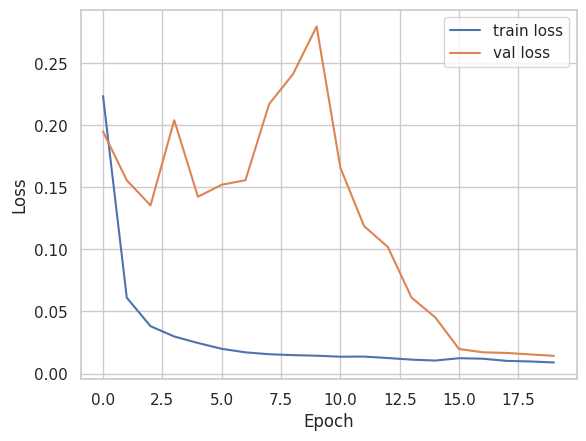

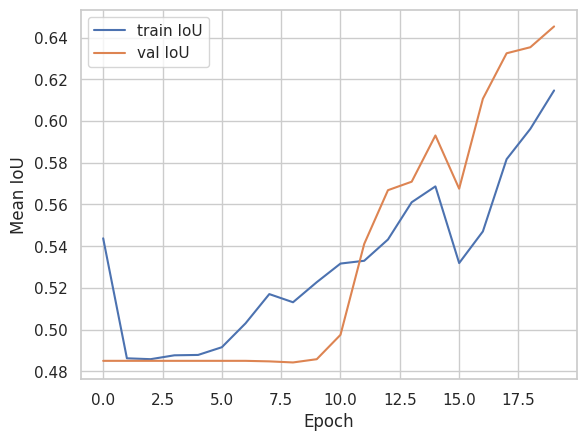

In [101]:
# PLOT TRAINING CURVES
# Loss
plt.figure()
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss');  plt.legend(); plt.show()

# Mean IoU
plt.figure()
plt.plot(history.history['mean_io_u'], label='train IoU')
plt.plot(history.history['val_mean_io_u'], label='val IoU')
plt.xlabel('Epoch'); plt.ylabel('Mean IoU'); plt.legend(); plt.show()

# **Segmentation model tuning**

In [102]:
# TUNING COMPILE & CHECKPOINT
model_seg.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)
checkpoint_cb_ft = tf.keras.callbacks.ModelCheckpoint(
    filepath='resunet_seg1_epoch.weights.h5',
    save_weights_only=True
)

In [103]:
# TUNING TRAIN
history = model_seg.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS + 40,
    callbacks=[checkpoint_cb_ft],
    verbose=1
)

Epoch 1/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 132s 853ms/step - loss: 0.0102 - mean_io_u_1: 0.6032 - val_loss: 0.0161 - val_mean_io_u_1: 0.6408
Epoch 2/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - loss: 0.0094 - mean_io_u_1: 0.6034 - val_loss: 0.0172 - val_mean_io_u_1: 0.6462
Epoch 3/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - loss: 0.0102 - mean_io_u_1: 0.5842 - val_loss: 0.0572 - val_mean_io_u_1: 0.5181
Epoch 4/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - loss: 0.0121 - mean_io_u_1: 0.5427 - val_loss: 0.0173 - val_mean_io_u_1: 0.5826
Epoch 5/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - loss: 0.0092 - mean_io_u_1: 0.5980 - val_loss: 0.0147 - val_mean_io_u_1: 0.5817
Epoch 6/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 263ms/step - loss: 0.0084 - mean_io_u_1: 0.6298 - val_loss: 0.0150 - val_mean_io_u_1: 0.6315
Epoch 7/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - loss: 0.0078 - mean_io_u_1: 0.6622 - val_loss: 0.0152 - val_mean_io_u_1: 0.6709
Epoch 8/60
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step -

In [104]:
model_seg.save('resunet_seg_final_ft.keras')
model_seg.save_weights('resunet_seg_final_ft.weights.h5')

In [105]:
print("Recorded history keys:", history.history.keys())

Recorded history keys: dict_keys(['loss', 'mean_io_u_1', 'val_loss', 'val_mean_io_u_1'])


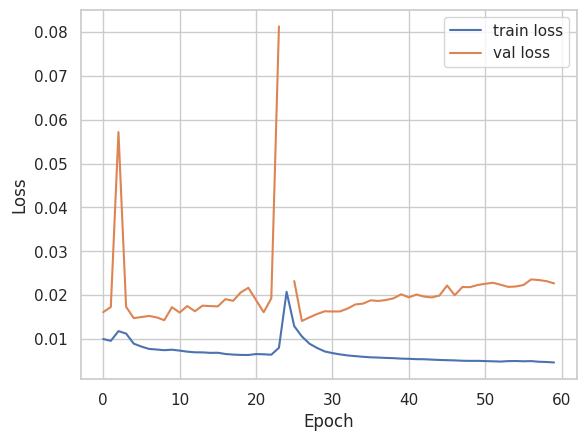

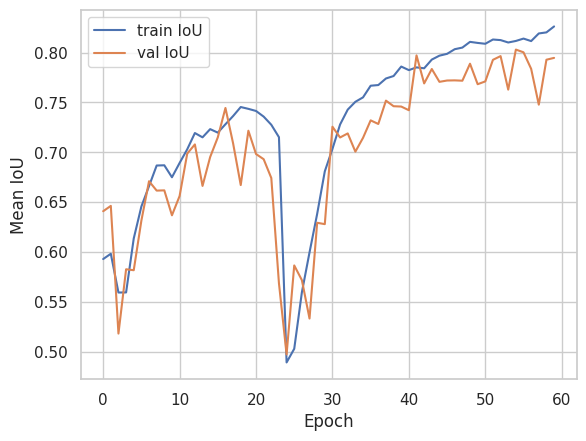

In [106]:
# PLOT TUNED TRAINING CURVES
# Loss
plt.figure()
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss');  plt.legend(); plt.show()

# Mean IoU
plt.figure()
plt.plot(history.history['mean_io_u_1'],     label='train IoU')
plt.plot(history.history['val_mean_io_u_1'], label='val IoU')
plt.xlabel('Epoch'); plt.ylabel('Mean IoU'); plt.legend(); plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


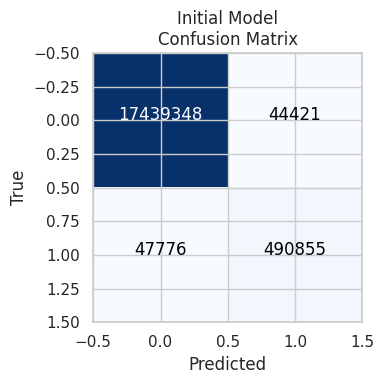

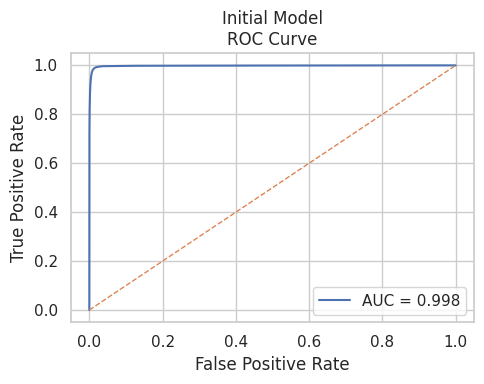

=== Initial Model Classification Report ===
              precision    recall  f1-score   support

         0.0     0.9973    0.9975    0.9974  17483769
         1.0     0.9170    0.9113    0.9141    538631

    accuracy                         0.9949  18022400
   macro avg     0.9571    0.9544    0.9558  18022400
weighted avg     0.9949    0.9949    0.9949  18022400



9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step


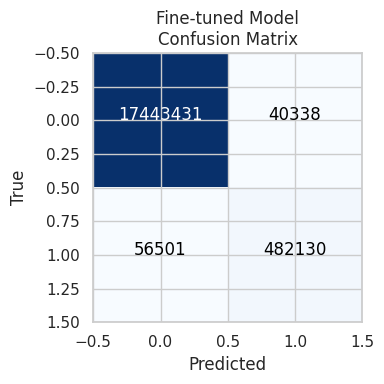

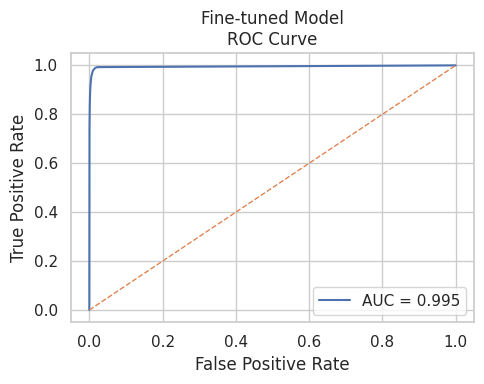

=== Fine‑tuned Model Classification Report ===
              precision    recall  f1-score   support

         0.0     0.9968    0.9977    0.9972  17483769
         1.0     0.9228    0.8951    0.9087    538631

    accuracy                         0.9946  18022400
   macro avg     0.9598    0.9464    0.9530  18022400
weighted avg     0.9946    0.9946    0.9946  18022400





In [107]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
)

model_init = build_resunet_instancenorm(input_shape=(*IMG_SIZE, 3))
model_init.load_weights('resunet_seg_epoch.weights.h5')

model_ft = load_model(
    'resunet_seg_final_ft.keras',
    custom_objects={'InstanceNormalization': InstanceNormalization}
)


# EXTRACT VAL SET
X_val_batches, y_val_batches = [], []
for Xb, yb in ds_val:
    X_val_batches.append(Xb.numpy()); y_val_batches.append(yb.numpy())
X_val = np.concatenate(X_val_batches, axis=0)
y_val = np.concatenate(y_val_batches, axis=0)
y_true = y_val.reshape(-1)

# EVALUATE & SAVE PLOTS
for name, model in [('Initial', model_init), ('Fine‑tuned', model_ft)]:
    y_prob = model.predict(X_val).reshape(-1)
    y_pred = (y_prob > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'{name} Model\nConfusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j],
                     ha='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.tight_layout()
    plt.savefig(f'cm_{name.lower()}.png', transparent=True, dpi=300)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--', linewidth=1)
    plt.title(f'{name} Model\nROC Curve')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'roc_{name.lower()}.png', transparent=True, dpi=300)
    plt.show()

    # Classification Report
    print(f'=== {name} Model Classification Report ===')
    print(classification_report(y_true, y_pred, digits=4))
    print('\n' + '='*40 + '\n')


9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step


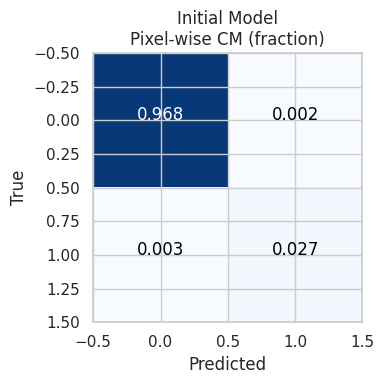

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


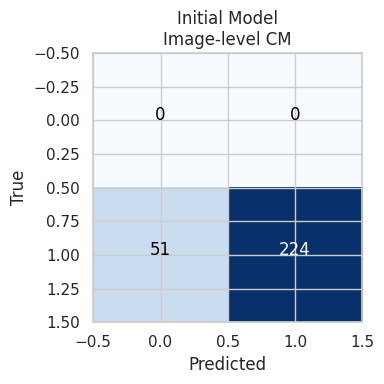

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 676ms/step


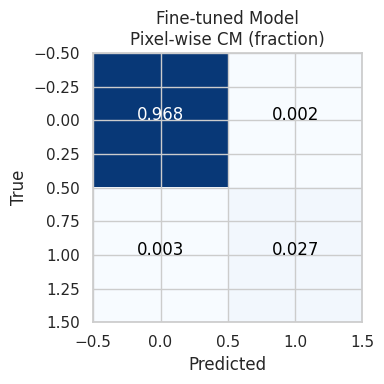

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


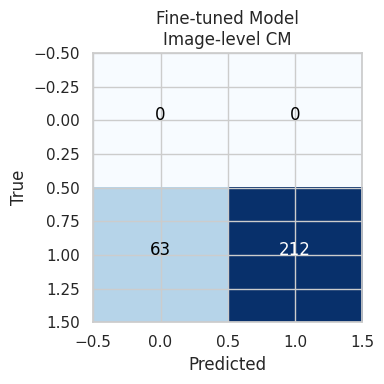

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import load_model

# 1) Rebuild/load models (as before)
model_init = build_resunet_instancenorm(input_shape=(*IMG_SIZE,3))
model_init.load_weights('resunet_seg_epoch.weights.h5')
model_ft   = load_model(
    'resunet_seg_final_ft.keras',
    custom_objects={'InstanceNormalization': InstanceNormalization}
)

# 2) Pull out X_val, y_val from ds_val
X_batches, y_batches = [], []
for Xb, yb in ds_val:
    X_batches.append(Xb.numpy()); y_batches.append(yb.numpy())
X_val = np.concatenate(X_batches, axis=0)      # (N,H,W,3)
y_val = np.concatenate(y_batches, axis=0)      # (N,H,W,1)
N, H, W, _ = X_val.shape

# flatten pixel‑wise truth
y_true_pix = y_val.reshape(-1)                 # (N*H*W,)

for name, model in [('Initial', model_init), ('Fine‑tuned', model_ft)]:
    # pixel‑wise predictions & labels
    y_prob_pix = model.predict(X_val).reshape(-1)
    y_pred_pix = (y_prob_pix > 0.5).astype(int)

    # ---- PIXEL‑LEVEL CONFUSION MATRIX (normalized) ----
    cm_pix = confusion_matrix(y_true_pix, y_pred_pix)
    cm_pix_norm = cm_pix.astype('float') / cm_pix.sum()  # fraction of all pixels

    plt.figure(figsize=(4,4))
    plt.imshow(cm_pix_norm, vmin=0, vmax=1, cmap='Blues')
    plt.title(f'{name} Model\nPixel‑wise CM (fraction)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{cm_pix_norm[i,j]:.3f}",
                     ha='center',
                     color='white' if cm_pix_norm[i,j]>0.5 else 'black')
    plt.tight_layout()
    plt.savefig(f'pixel_cm_{name.lower()}.png', transparent=True, dpi=300)
    plt.show()

    # ---- IMAGE‑LEVEL METRICS
    # turn each 256×256 mask into “any tumor?” label:
    y_prob_imgs = model.predict(X_val).reshape(N, H*W).mean(axis=1)
    # you can swap mean()>0.5 for sum()>0 or any threshold
    y_pred_img  = (y_prob_imgs > 0.01).astype(int)
    y_true_img  = (y_val.reshape(N, H*W).sum(axis=1) > 0).astype(int)

    # Image‑level confusion matrix
    cm_img = confusion_matrix(y_true_img, y_pred_img)
    plt.figure(figsize=(4,4))
    plt.imshow(cm_img, cmap='Blues')
    plt.title(f'{name} Model\nImage‑level CM')
    plt.xlabel('Predicted'); plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm_img[i,j],
                     ha='center',
                     color='white' if cm_img[i,j] > cm_img.max()/2 else 'black')
    plt.tight_layout()
    plt.savefig(f'image_cm_{name.lower()}.png', transparent=True, dpi=300)
    plt.show()


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable


@register_keras_serializable()
class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # create trainable scale & offset parameters
        self.scale = self.add_weight(
            name='scale',
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        # compute instance mean & variance
        mean, var = tf.nn.moments(inputs, axes=[1,2], keepdims=True)
        inv = tf.math.rsqrt(var + self.epsilon)
        normalized = (inputs - mean) * inv
        return self.scale * normalized + self.offset

# Load segmentation model
seg_model = load_model(
    '/content/data_final/kaggle_3m/resunet_seg_final_ft.keras',
    custom_objects={'InstanceNormalization': InstanceNormalization}
)

# Load test DataFrame (CSV with columns 'image_path' & 'mask_path')
df_seg = pd.read_csv('/content/data_final/kaggle_3m/data_mask.csv')
df_seg = df_seg[['image_path', 'mask_path']]

# Build image & mask generators
IMG_SIZE = (256, 256)
BATCH_SIZE = 8

img_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator()

img_gen = img_datagen.flow_from_dataframe(
    df_seg, x_col='image_path', class_mode=None,
    target_size=IMG_SIZE, color_mode='rgb',
    batch_size=BATCH_SIZE, shuffle=False, seed=42
)

mask_gen = mask_datagen.flow_from_dataframe(
    df_seg, x_col='mask_path', class_mode=None,
    target_size=IMG_SIZE, color_mode='grayscale',
    batch_size=BATCH_SIZE, shuffle=False, seed=42
)

# Predict & collect arrays
y_true_masks = []
y_pred_masks = []
x_test_seg = []

steps = int(np.ceil(len(df_seg) / BATCH_SIZE))
for (img_batch, mask_batch) in zip(img_gen, mask_gen):
    preds = seg_model.predict(img_batch)
    preds_bin = (preds > 0.5).astype(np.uint8)

    for i in range(img_batch.shape[0]):
        y_true_masks.append(mask_batch[i].squeeze())
        y_pred_masks.append(preds_bin[i].squeeze())
        x_test_seg.append(img_batch[i].squeeze())

    if len(x_test_seg) >= len(df_seg):
        break

x_test_seg   = np.array(x_test_seg)
y_true_masks = np.array(y_true_masks)
y_pred_masks = np.array(y_pred_masks)




Found 3929 validated image filenames.
Found 3929 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

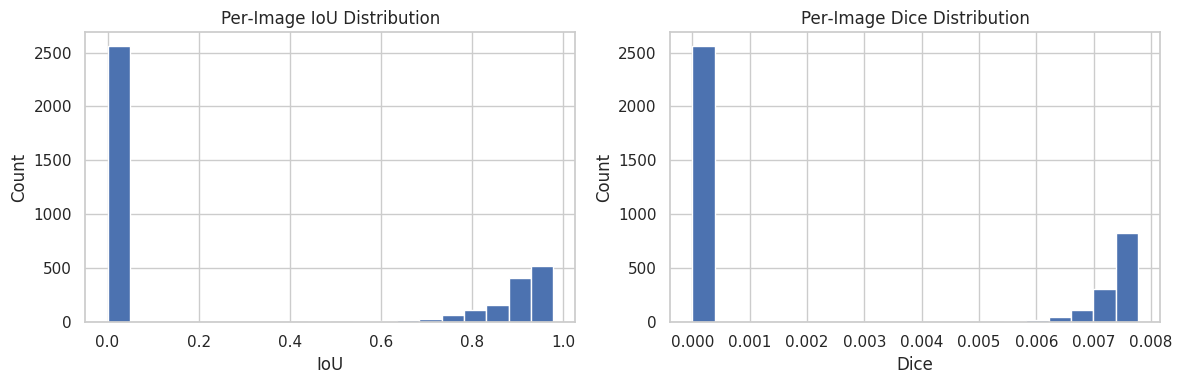

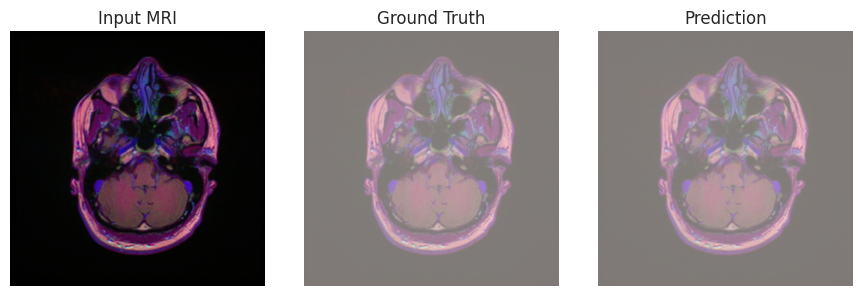

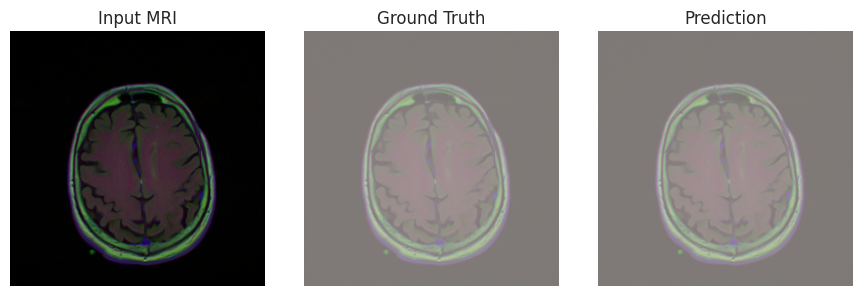

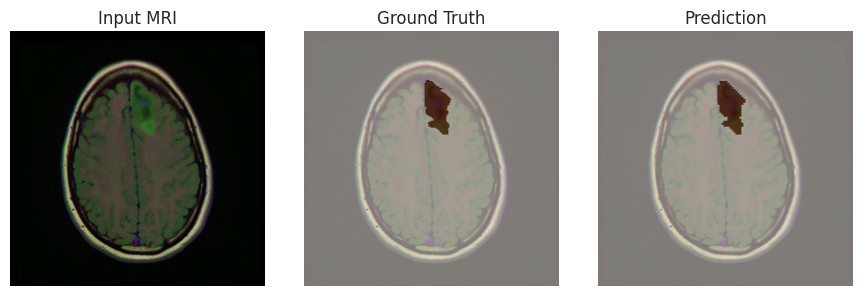

In [112]:
# Visualization of performance

# IoU and Dice distributions
ious = []
dices = []
for gt, pr in zip(y_true_masks, y_pred_masks):
    inter = np.logical_and(gt, pr).sum()
    union = np.logical_or(gt, pr).sum()
    ious.append(inter/union if union>0 else 0)
    dices.append(2*inter/(gt.sum()+pr.sum()) if (gt.sum()+pr.sum())>0 else 0)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(ious, bins=20)
plt.title("Per‑Image IoU Distribution")
plt.xlabel("IoU"); plt.ylabel("Count")
plt.subplot(1,2,2)
plt.hist(dices, bins=20)
plt.title("Per‑Image Dice Distribution")
plt.xlabel("Dice"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig('/content/segmentation_iou_dice_histograms.png', transparent=True, bbox_inches='tight')
plt.show()

# Qualitative overlays on random samples
import random
sample_idxs = random.sample(range(len(x_test_seg)), 3)
for idx in sample_idxs:
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    img = x_test_seg[idx]
    gt  = y_true_masks[idx]
    pr  = y_pred_masks[idx]
    axs[0].imshow(img, cmap='gray'); axs[0].set_title("Input MRI"); axs[0].axis('off')
    axs[1].imshow(img, cmap='gray'); axs[1].imshow(gt, alpha=0.5, cmap='Reds'); axs[1].set_title("Ground Truth"); axs[1].axis('off')
    axs[2].imshow(img, cmap='gray'); axs[2].imshow(pr, alpha=0.5, cmap='Reds'); axs[2].set_title("Prediction"); axs[2].axis('off')
    plt.tight_layout()
    plt.savefig(f'/content/overlay_{idx}.png', transparent=True, bbox_inches='tight')
    plt.show()